In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time, glob,warnings, glob
from scipy.stats import *
from itertools import combinations
from astropy.io import fits
import pickle
import seaborn as sns
import healpy as hp

/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/db/opsimDatabase.py:95: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if groupBy is 'default' and tableName==self.defaultTable:
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/db/opsimDatabase.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if groupBy is 'default' and tableName!=self.defaultTable:
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:127: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  (key is not 'bins') & (key is not 'binCol'):
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:127: SyntaxWarning: "is not" with a literal. Did yo

In [2]:
data_file = glob.glob('./data_file/*')

In [30]:
maf = {}
for db in data_file:
    tmp= np.load(db)
    tmp.allow_pickle = True
    maf[db]= tmp['metricValues'][np.where(tmp['mask']==False)]

In [ ]:
dist_file = glob.glob('./dist_file/*')

In [17]:
dist = {}
for db in dist_file:
    print(db)
    dumb= np.load(db)
    dumb.allow_pickle = True
    dist[db]= dumb['metricValues'][np.where(dumb['mask']==False)]  

In [146]:
from matplotlib.patches import Circle
import matplotlib.transforms as transforms
def limits(x1,y1,x2,y2,ax,facecolor='none', **kwargs):
    xc,yc= np.mean(x2),np.mean(y2)
    if len(x1)>0:
        dist=np.linalg.norm(np.column_stack([x1,y1])-np.array([xc,yc]),axis=1)
        r = dist[np.argmin(dist)]
        print(r)
        circle = Circle((xc,yc), radius = r,
                      facecolor='None',edgecolor='black', **kwargs)
    else:
        dist=np.linalg.norm(np.column_stack([x2,y2])-np.array([xc,yc]), axis=1)
        r = dist[np.argmax(dist)]
        circle = Circle((xc,yc), radius = 3*r, facecolor='None',edgecolor='black',linewidth=2)   
    return ax.add_patch(circle)

In [87]:
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

1.2151654280639446
0.841275315289477
1.6319675176670247
0.8875817884911111
2.5506531398748042
0.9623536904839393


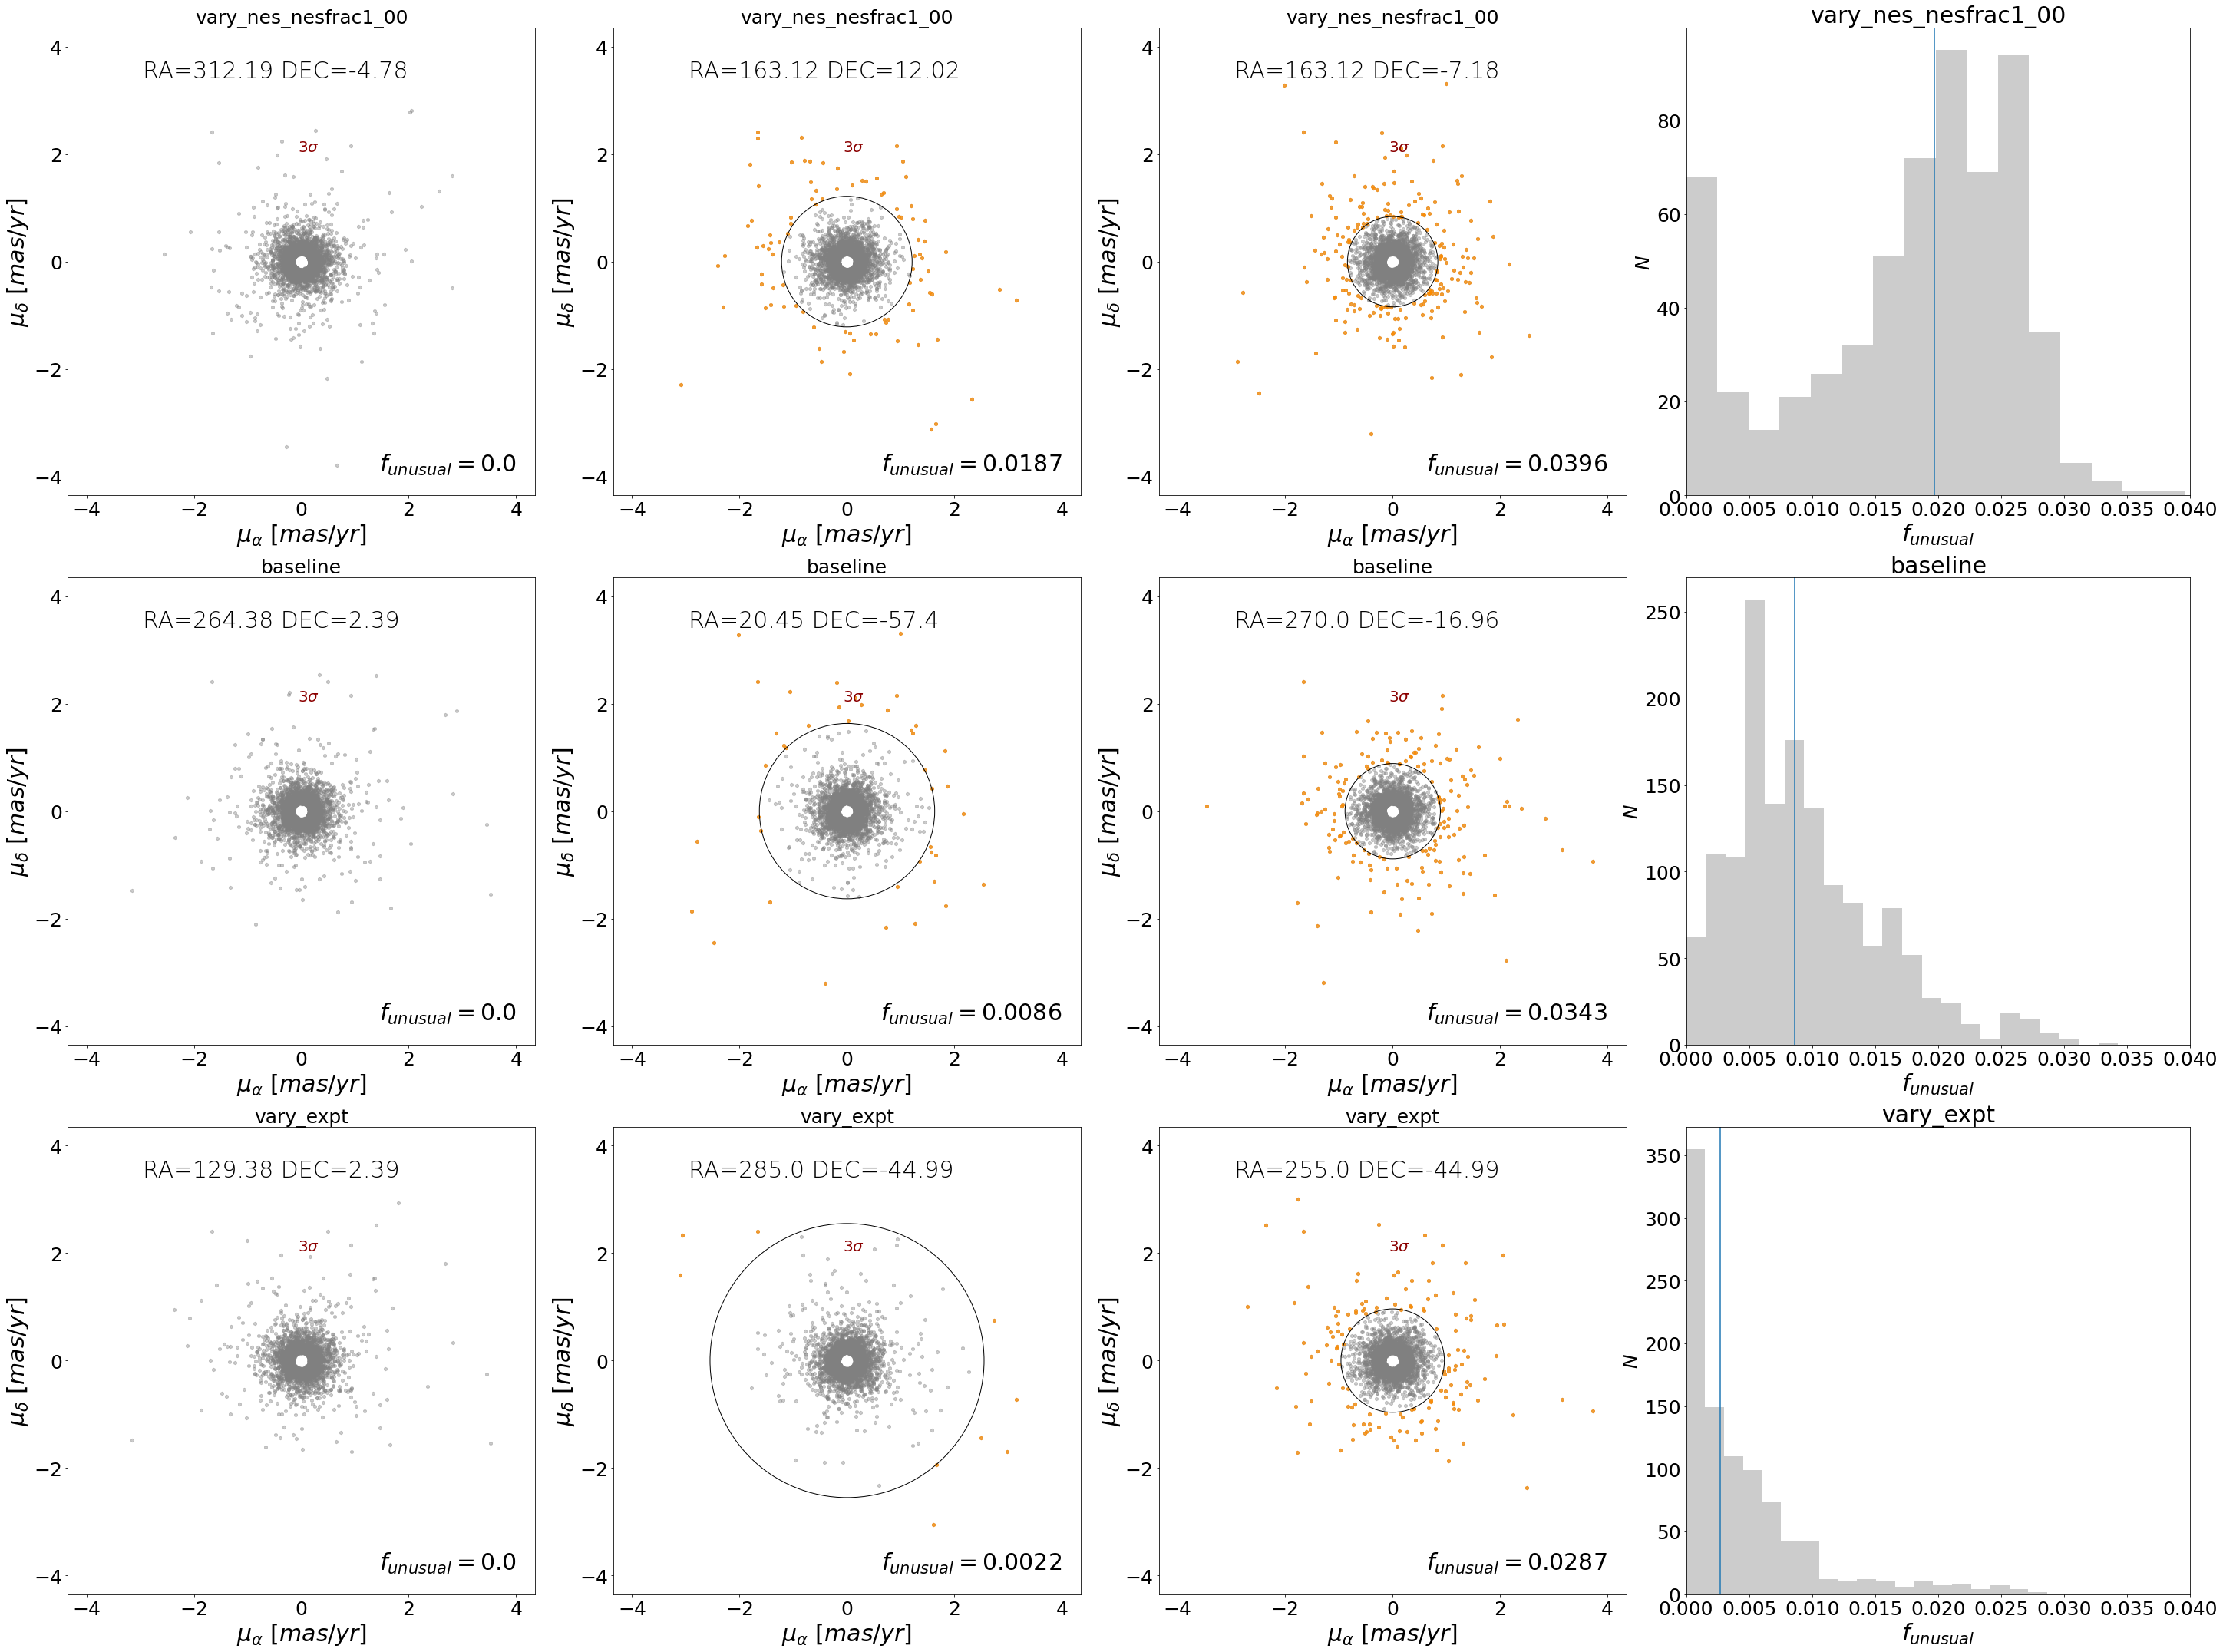

In [147]:
fig, axs= plt.subplots(3,4,figsize=(40,30))
for j,(d,t) in enumerate(zip([ './Anomaliesv2.0_LSplot_v2/_sims_maf_fbs_2_0_vary_nes_vary_nes_nesfrac1_00_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_USER.npz',
'./Anomaliesv2.0_LSplot_v2/_sims_maf_fbs_2_0_baseline_baseline_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_USER.npz',
'./Anomaliesv2.0_LSplot_v2/_sims_maf_fbs_2_0_vary_expt_vary_expt_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_USER.npz'],
                               ['vary_nes_nesfrac1_00','baseline','vary_expt'])):
    
    
    detected = np.array([(maf[d][i]["detected"] if not maf[d][i] is None else np.nan) for i in range(len(maf[d])) ])

    #sort by metric value - make sure you account for NaNs
    indx = np.argsort(detected)
    nans = np.isnan(detected).sum()
    median = int((len(detected) - nans) / 2 )
    
    for i in [0,1,2]:
        axs[j,i].set(adjustable='box', aspect=1)
        if i==0:
            m = maf[d][indx[0]] # minimum LS result
        if i==1:
            m = maf[d][indx[median]] # median LS result
        if i==2:
            m = maf[d][indx[-nans-1]] # best LS result
        pm = m['PM']*10**3
        pm_un = m['PM_un']*10**3
        pm_un_det = m['PM_un_det']*10**3
        pix = m['pixID']
        det = m['detected']
        sigma = m['sigma']
        #print(np.size(pm))
        #n_in = np.size(pm.pm_alpha)
        contour =  limits(pm_un_det.pm_alpha,pm_un_det.pm_delta,pm.pm_alpha, pm.pm_delta,ax=axs[j,i]) #confidence_ellipse(pm.pm_alpha, pm.pm_delta,n_std=3.0, extra=sigma**2,ax=axs[j,i],label=r'$3\sigma$', 
                             #        edgecolor='black', linestyle='-', linewidth=3, zorder=100)
        
        points=axs[j,i].transData.transform(np.array([pm_un.pm_alpha, pm_un.pm_delta]).T)
        id_p = contour.contains_points(points)
        
        #n_out = np.size(pm_un.pm_alpha[id_p])
        #print(np.sum(id_p))
        #ax.plot(p_[:,0],p_[:,1],'-',color='black',lw=2)
        axs[j,i].scatter(pm_un.pm_alpha,pm_un.pm_delta,marker='h',s=20, color='grey',alpha =0.4)
        axs[j,i].scatter(pm_un_det.pm_alpha,pm_un_det.pm_delta,marker='h',s=20, color='darkorange',alpha=0.7)
        axs[j,i].text(-.07,2.05,r'$3\sigma$',  weight='bold', fontsize=20,color='darkred')
        #axs[j,i].text(-.07,0.03,r'$1\sigma$', weight='bold',fontsize=20,color='darkred',zorder=100)
        axs[j,i].set_xlim([-4.35,4.35])
        axs[j,i].set_ylim([-4.35,4.35])
        axs[j,i].set_yticks([-4, -2, 0, 2, 4])
        axs[j,i].set_xlabel(r'$\mu_{\alpha}$ '+r'$[mas/yr]$',fontsize=30)
        axs[j,i].set_ylabel(r'$\mu_{\delta}$ '+r'$[mas/yr]$',fontsize=30)
        axs[j,i].set_title('{}'.format(t), fontsize=25)
        RA,DEC= pix2radec(16,pix)
        axs[j,i].tick_params('both', labelsize=25)
        axs[j,i].annotate('RA={} DEC={}'.format(np.round(RA,2),np.round(DEC,2)),
                  (-2.95,3.75),fontsize=30,fontweight=3, ha='left', va="top")
        axs[j,i].annotate(r'$f_{unusual}= $'+r'${}$'.format(np.round(det,4)),
                  (4,-4),fontsize=30,fontweight=3, ha='right', va="bottom")
    if j==0:
        l = 2
    elif j==1:
        l=1
    else:
        l=3
    sns.distplot(dist[dist_file[l]][np.isfinite(dist[dist_file[l]])], ax=axs[j,3], 
                bins=int(2*np.power(np.size(dist[dist_file[l]][np.isfinite(dist[dist_file[l]])]),1/3.)),
                hist=True, kde=False, rug=False, fit=None, hist_kws={'alpha':0.4,'lw':3,'color':'grey'}, )
    axs[j,3].set_title('{}'.format(t), fontsize=30)
    axs[j,3].set_xlabel(r'$f_{unusual}$',fontsize=30)
    axs[j,3].set_ylabel(r'$N$',fontsize=25)
    axs[j,3].set_xlim([0,0.04])
    axs[j,3].tick_params('both', labelsize=25)
    #axs[j,3].set_ylim([0,150])
    #axs[j,3].set_aspect(aspect='equal',adjustable='box')
    _ = np.median(dd[result[l]][np.isfinite(dd[result[l]])])
    axs[j,3].axvline(_)  
    #axs[j,3].set_ylim([0,150])
    #axs[j,3].set_aspect(aspect='equal',adjustable='box')
plt.subplots_adjust(wspace = 0, left=None, right=None)
plt.tight_layout()
plt.savefig('contour_plot.png')